1. Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import joblib


2. Load Data

In [12]:
data = pd.read_csv('./data/data.csv')

data.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


3. Exploratory Data Analysis

In [6]:
data.columns

Index(['Age', 'Gender', 'Income', 'Education', 'Marital Status',
       'Number of Children', 'Home Ownership', 'Credit Score'],
      dtype='object')

In [7]:
data.shape

(164, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 164 non-null    int64 
 1   Gender              164 non-null    object
 2   Income              164 non-null    int64 
 3   Education           164 non-null    object
 4   Marital Status      164 non-null    object
 5   Number of Children  164 non-null    int64 
 6   Home Ownership      164 non-null    object
 7   Credit Score        164 non-null    object
dtypes: int64(3), object(5)
memory usage: 10.4+ KB


In [9]:
data.describe()

,Age,Income,Number of Children
count,164.000000,164.000000,164.000000
mean,37.975610,83765.243902,0.652439
std,8.477289,32457.306728,0.883346
min,25.000000,25000.000000,0.000000
25%,30.750000,57500.000000,0.000000
50%,37.000000,83750.000000,0.000000
75%,45.000000,105000.000000,1.000000
max,53.000000,162500.000000,3.000000


In [10]:
data.isnull().sum()

Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64

In [18]:
data.head()

,Age,Gender,Income,Education,Marital Status,Number of Children,Home Ownership,Credit Score
0,25,Female,50000,Bachelor's Degree,Single,0,Rented,High
1,30,Male,100000,Master's Degree,Married,2,Owned,High
2,35,Female,75000,Doctorate,Married,1,Owned,High
3,40,Male,125000,High School Diploma,Single,0,Owned,High
4,45,Female,100000,Bachelor's Degree,Married,3,Owned,High


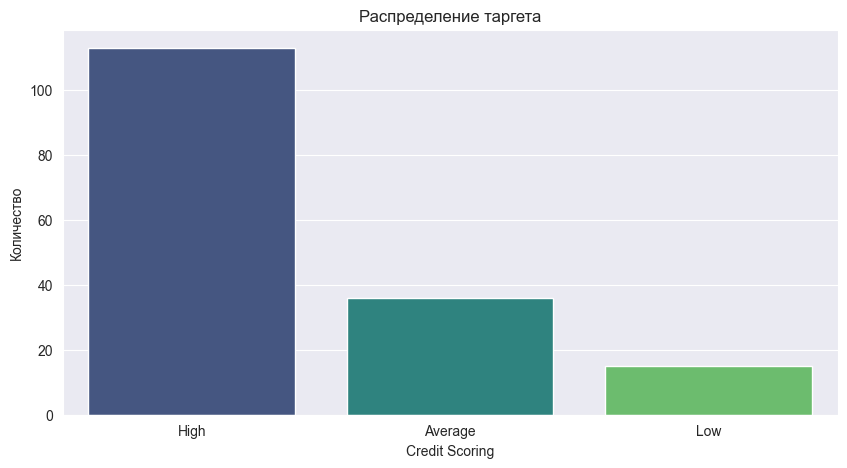

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x="Credit Score", hue="Credit Score", order=data['Credit Score'].value_counts().index, palette='viridis')
plt.title('Распределение таргета')
plt.ylabel('Количество')
plt.xlabel('Credit Scoring')
plt.show()

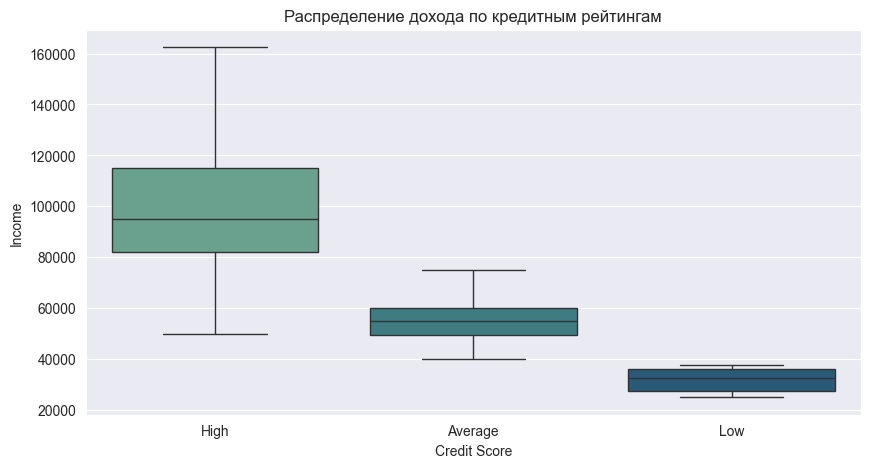

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data, x='Credit Score', y='Income', hue='Credit Score', order=data['Credit Score'].value_counts().index, palette='crest')
plt.title('Распределение дохода по кредитным рейтингам')
plt.show()

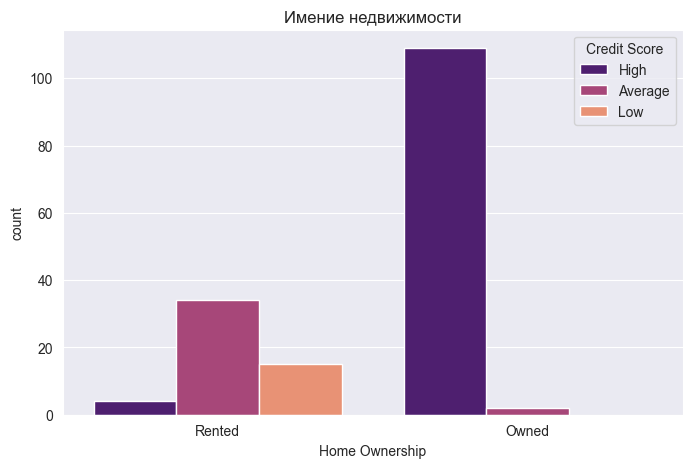

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Home Ownership', hue='Credit Score', palette='magma')
plt.title('Имение недвижимости')
plt.show()

In [30]:
data.isnull().sum()

Age                   0
Gender                0
Income                0
Education             0
Marital Status        0
Number of Children    0
Home Ownership        0
Credit Score          0
dtype: int64

In [31]:
data.columns

Index(['Age', 'Gender', 'Income', 'Education', 'Marital Status',
       'Number of Children', 'Home Ownership', 'Credit Score'],
      dtype='object')

In [32]:
data.dtypes

Age                    int64
Gender                object
Income                 int64
Education             object
Marital Status        object
Number of Children     int64
Home Ownership        object
Credit Score          object
dtype: object

In [33]:
num_cols = [
    'Age',
    'Income',
    'Number of Children'
]

cat_cols = [
    'Gender',
    'Education',
    'Marital Status',
    'Home Ownership',
]

target_column = 'Credit Score'

In [34]:
X = data.drop(columns=[target_column])
y = data[target_column]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(131, 7) (33, 7)
(131,) (33,)


4. Building Pipeline

In [40]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, num_cols),
        ('categorical', cat_transformer, cat_cols)
    ], remainder='drop'
)

In [41]:
log_reg = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight='balanced')

random_forest = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1)


#pipeline for Random Forest

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', random_forest)
])

#pipeline for Logistic Regression

log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', log_reg)
])

In [42]:
rf_param_distributions = {
    "model__n_estimators": [200, 300, 400, 600, 800],
    "model__max_depth": [None, 5, 10, 15, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=30,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

In [48]:
lr_param_distributions = {
    "model__penalty": ['l1', 'l2', 'elasticnet', None],
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "model__solver": ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    "model__max_iter": [100, 200, 500, 1000, 2000],
    "model__class_weight": [None, 'balanced'],
}

lr_search = RandomizedSearchCV(
    estimator=log_reg_pipeline,
    param_distributions=lr_param_distributions,
    n_iter=10,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

5. Fit with cross validation

In [44]:
rf_search.fit(X_train, y_train)
print("Best CV score (f1_macro):", rf_search.best_score_)
print("Best params:", rf_search.best_params_)

best_model = rf_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV score (f1_macro): 0.9657912457912458
Best params: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 1.0, 'model__max_depth': 15}


--- Classification Report ---
              precision    recall  f1-score   support

     Average       1.00      1.00      1.00         7
        High       1.00      1.00      1.00        23
         Low       1.00      1.00      1.00         3

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

--- Confusion Matrix Plot ---


<Figure size 800x600 with 0 Axes>

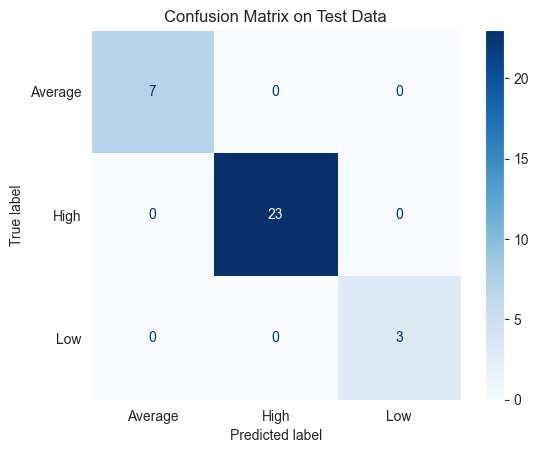

In [50]:
y_pred = best_model.predict(X_test)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))


print("--- Confusion Matrix Plot ---")
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Data')
plt.grid(False) # Turn off grid for cleaner look
plt.show()

In [51]:
try:
    y_proba = best_model.predict_proba(X_test)
    if y_proba.ndim == 2 and y_proba.shape[1] > 2:
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    else:
        auc = roc_auc_score(y_test, y_proba[:, 1])
    print("ROC-AUC:", auc)
except Exception as e:
    print("ROC-AUC not available:", e)

# Persist the best model
joblib.dump(best_model, 'best_credit_score_model.joblib')
print("Saved model to best_credit_score_model.joblib")

ROC-AUC: 1.0
Saved model to best_credit_score_model.joblib


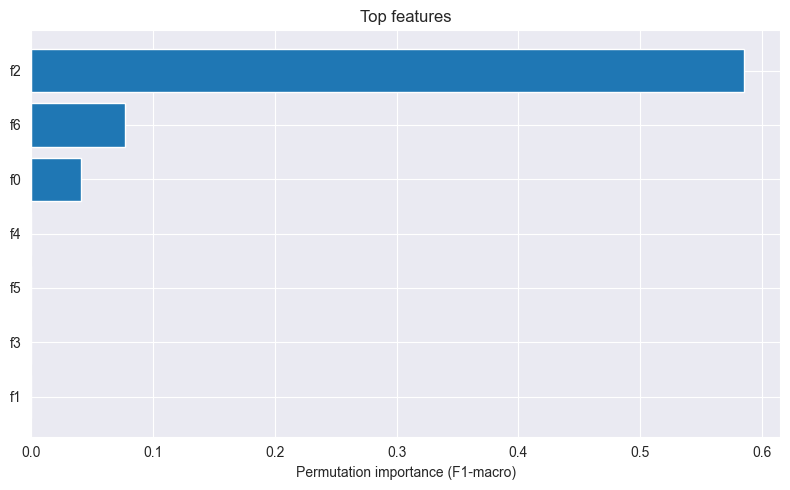

In [52]:
def get_preprocessed_feature_names(preprocessor: ColumnTransformer) -> list:
    output_features = []
    if num_cols:
        output_features.extend(num_cols)
    if cat_cols:
        try:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            ohe_features = ohe.get_feature_names_out(cat_cols).tolist()
        except Exception:
            ohe_features = []
        output_features = output_features + ohe_features
    return output_features


try:
    # Grab the fitted preprocessing + model pipeline
    fitted_pre = best_model.named_steps['preprocess']
    feature_names = get_preprocessed_feature_names(fitted_pre)
except Exception:
    feature_names = None

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='f1_macro'
)
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

top_k = min(15, len(importances))
plt.figure(figsize=(8, 5))
labels = [feature_names[i] if feature_names is not None and i < len(feature_names) else f"f{i}" for i in indices[:top_k]]
plt.barh(range(top_k), importances[indices[:top_k]][::-1])
plt.yticks(range(top_k), labels[::-1])
plt.xlabel('Permutation importance (F1-macro)')
plt.title('Top features')
plt.tight_layout()
plt.show()

In [53]:
import joblib
import pandas as pd

loaded_pipeline = joblib.load('best_credit_score_model.joblib')


raw_test_data = pd.DataFrame({
    'Age': [30],
    'Gender': ['Female'],
    'Income': [75000],
    'Education': ["Master's Degree"],
    'Marital Status': ['Married'],
    'Number of Children': [1],
    'Home Ownership': ['Owned']
})

# --- Test the prediction ---
# If this line runs successfully, the pipeline was saved correctly!
prediction = loaded_pipeline.predict(raw_test_data)
probability = loaded_pipeline.predict_proba(raw_test_data)

print(f"Prediction for raw data: {prediction[0]}")
print(f"Prediction Probabilities: {probability[0]}")

Prediction for raw data: High
Prediction Probabilities: [0.14333333 0.85666667 0.        ]
